In [1]:
import os
from pathlib import Path

import numpy as np
from tqdm.notebook import trange
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from dpipe.io import load, choose_existing
from dpipe.torch import load_model_state

from ttt_lib.policy_player import PolicyPlayer, play_self_game, play_duel
from ttt_lib.torch.module.policy_net import PolicyNetworkRandom, PolicyNetworkQ10Light, PolicyNetworkQ10
from ttt_lib.field import Field
from ttt_lib.utils import choose_model

pygame 2.0.2 (SDL 2.0.16, Python 3.8.5)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
Q_EXP_PATH = choose_existing(
    Path('/nmnt/x4-hdd/experiments/rl/q_10x10'),
)

os.listdir(Q_EXP_PATH)

['q8_stoch_iter_load45',
 'tb8_large',
 'q8_test',
 'q10_load45',
 'tb8_45_tb8_32_tb8_50_eps05',
 'tb8_45_tb8_32_tb8_50_eps04',
 'q8_stoch_ep_load45',
 'q4_test',
 'q8_large',
 'tb8_load45_load32',
 'ql8_load45_load32',
 'q2_test',
 'q6_test',
 'q8_load45']

# Visualization

In [3]:
exp_path = Q_EXP_PATH / 'tb8_45_tb8_32_tb8_50_eps05'

In [4]:
device = 'cpu'
n = 10
kernel_len = 5
cnn_features = (128, 64)

field = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)
model = PolicyNetworkQ10Light(n=n, structure=cnn_features)
# model = PolicyNetworkQ10(n=n, structure=cnn_features)
load_model_state(model, exp_path / choose_model(exp_path))

eps = 0
player = PolicyPlayer(model=model, field=field, eps=eps, device=device)
player.eval()

In [5]:
s_history, f_history, a_history, q_history, q_max_history, p_history, e_history, value\
    = play_self_game(player=player, train=False, augm=False)

/nmnt/media/home/boris/workspace/RL2021_Final_Project/ttt_lib/policy_player.py:40: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  argmax_avail_action_idx = random.choice(torch.where(avail_p == avail_p.max(), 1., 0.).nonzero()).item()


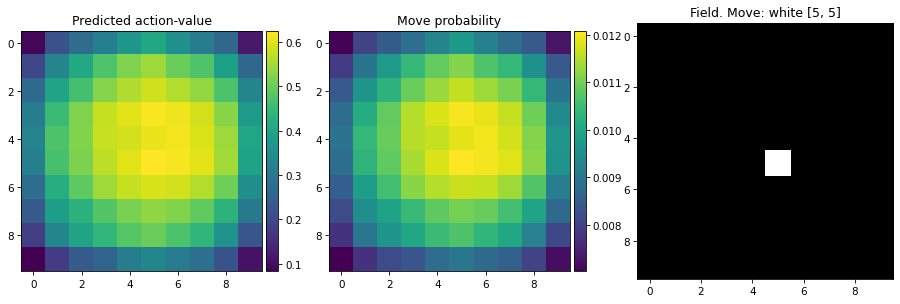

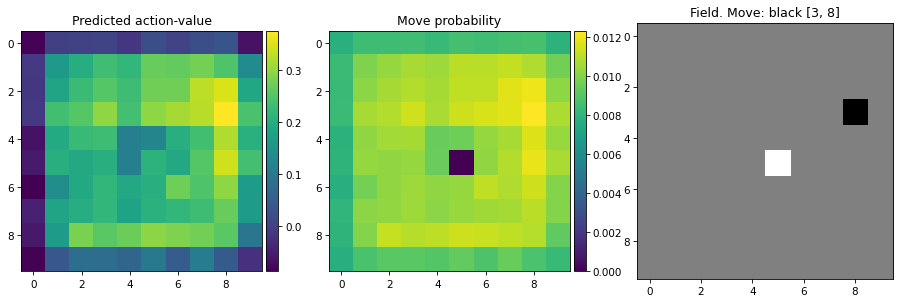

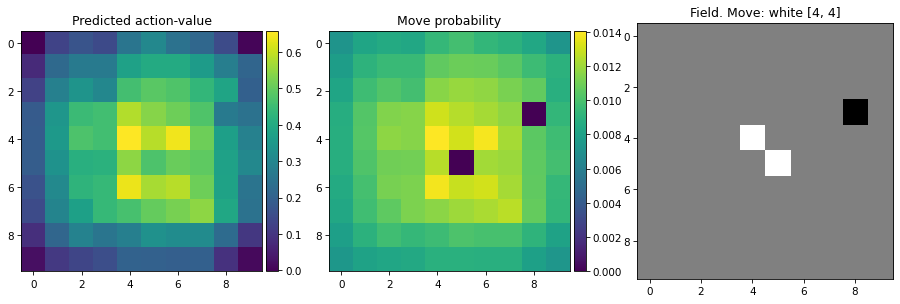

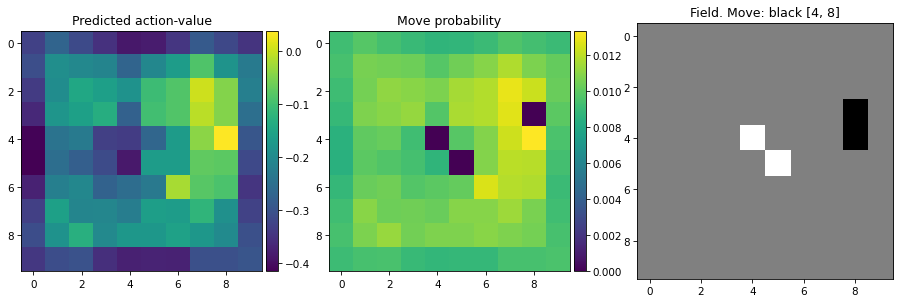

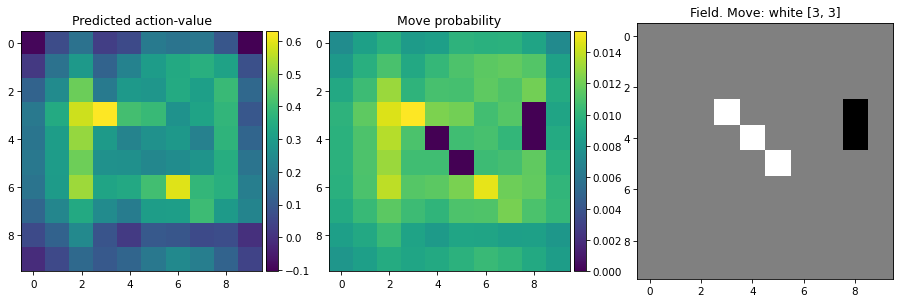

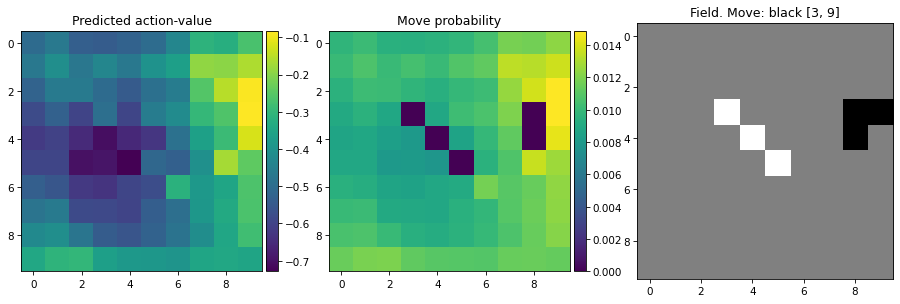

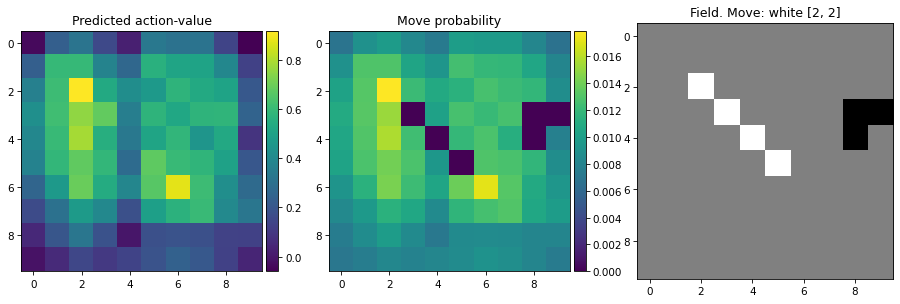

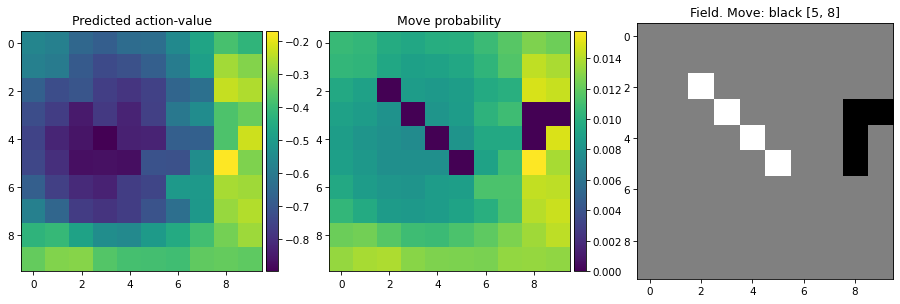

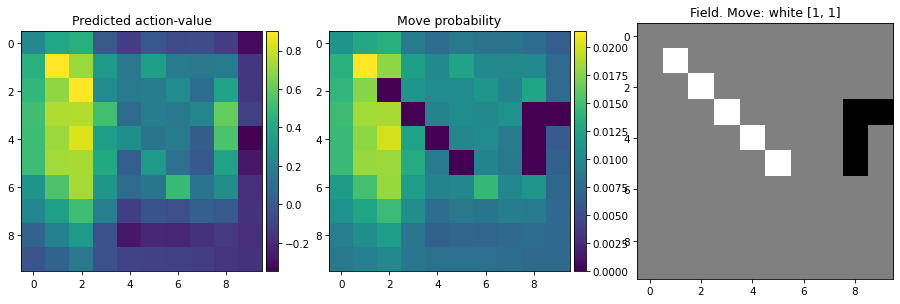

In [6]:
field_v = Field(n, kernel_len)

for s, a, q, p in zip(s_history, a_history, q_history, p_history):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=75)
    
    im = axes[0].imshow(q.detach().numpy(), interpolation='None')
    axes[0].set_title('Predicted action-value')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    
    im = axes[1].imshow(p.detach().numpy(), interpolation='None')
    axes[1].set_title('Move probability')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    

    i, j = a // n, a % n
    field_v.set_state(s)
    field_v.make_move(i, j)
    _state = field_v.get_state()
    _player = {-1: 'black', 1: 'white'}[-field_v.next_action_id]

    axes[2].imshow(_state, cmap='gray')
    axes[2].set_title(f'Field. Move: {_player} [{i}, {j}]')
    
    plt.show()

## Check some manual games

In [7]:
player.update_field(np.zeros((n, n), dtype='float32'))

### Algorithm's policy w/o move

Suggested move: 2 0


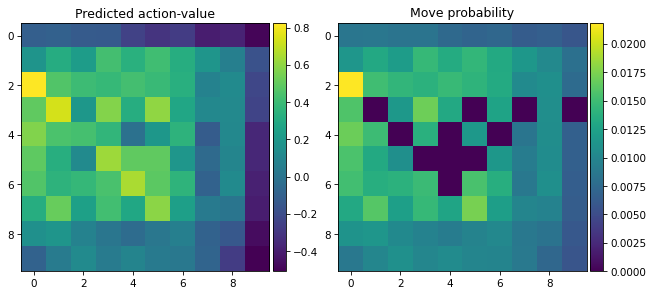

In [23]:
q, p = player.forward_state()

a = p.argmax()
print('Suggested move:', a.item() // n, a.item() % n)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=75)
    
im = axes[0].imshow(q.detach().numpy(), interpolation='None')
axes[0].set_title('Predicted action-value')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
    
im = axes[1].imshow(p.detach().numpy(), interpolation='None')
axes[1].set_title('Move probability')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.show()

### Algorithm's move

None


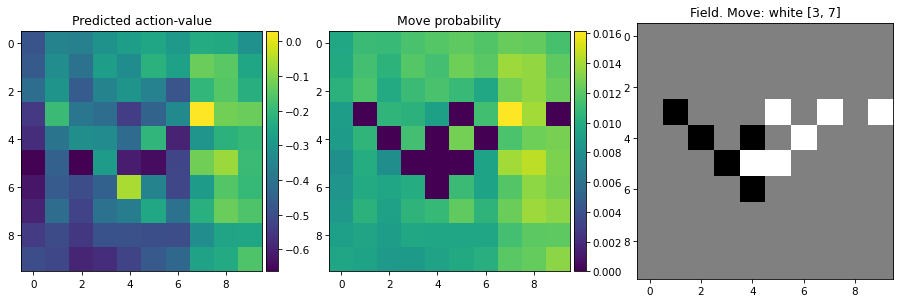

In [22]:
q, p, a, e, v = player.action(train=False)

print(v)

fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=75)
    
im = axes[0].imshow(q.detach().numpy(), interpolation='None')
axes[0].set_title('Predicted action-value')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(p.detach().numpy(), interpolation='None')
axes[1].set_title('Move probability')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')
    

i, j = a // n, a % n
_state = player.field.get_state()
_player = {-1: 'black', 1: 'white'}[-player.field.next_action_id]

axes[2].imshow(_state, cmap='gray')
axes[2].set_title(f'Field. Move: {_player} [{i}, {j}]')
    
plt.show()

### Manual move

None


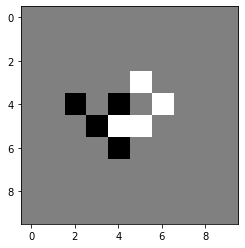

In [18]:
_, _, _, _, v = player.manual_action(4, 2)

print(v)

player.field.show_field()

# Duels

In [24]:
field_duel = Field(n=n, kernel_len=kernel_len, device=device, check_device=device)

eps = 0.2

In [25]:
model_random = PolicyNetworkRandom(n=n)
player_random = PolicyPlayer(model=model_random, field=field_duel, eps=1., device=device)

## TB8 (77ep) vs TB8 (117ep)

In [30]:
player_model_tb8_77 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                   field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q8_load45/')
load_model_state(player_model_tb8_77.model, path / choose_model(path))


player_model_tb8_117 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                    field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/tb8_load45_load32/')
load_model_state(player_model_tb8_117.model, path / choose_model(path))

In [18]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8, player_model_tb8_1


for _ in trange(1000):
    sh, fh, ah, qh, ph, eh, w = play_duel(p1, p2, return_result_only=False)
    res_1.append(w)
    
    sh, fh, ah, qh, ph, eh, w = play_duel(p2, p1, return_result_only=False)
    res_2.append(w)

In [19]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

0.554
0.0
0.446


In [20]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.711
0.0
0.289


# TB8 (45ep) vs TB6 (48ep) vs TB4 (54ep)

In [21]:
# TB2 has been trained only for 11 epochs


player_model_tb4_54 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                   field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q4_test/')
load_model_state(player_model_tb4_54.model, path / choose_model(path))


player_model_tb6_48 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                   field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q6_test/')
load_model_state(player_model_tb6_48.model, path / choose_model(path))


player_model_tb8_45 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                   field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q8_test/')
load_model_state(player_model_tb8_45.model, path / choose_model(path))

In [23]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8_45, player_model_tb6_48


for _ in trange(1000):
    sh, fh, ah, qh, ph, eh, w = play_duel(p1, p2, return_result_only=False)
    res_1.append(w)
    
    sh, fh, ah, qh, ph, eh, w = play_duel(p2, p1, return_result_only=False)
    res_2.append(w)

In [24]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

0.57
0.0
0.43


In [25]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.437
0.0
0.563


In [26]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8_45, player_model_tb4_54


for _ in trange(1000):
    sh, fh, ah, qh, ph, eh, w = play_duel(p1, p2, return_result_only=False)
    res_1.append(w)
    
    sh, fh, ah, qh, ph, eh, w = play_duel(p2, p1, return_result_only=False)
    res_2.append(w)

In [27]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

0.699
0.0
0.301


In [28]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.372
0.0
0.628


# TB8 (77 ep) vs TB8 (45ep) + TB10 (34 ep)

In [29]:
player_model_tb8_45_tb10_34 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                           field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/q10_load45/')
load_model_state(player_model_tb8_45_tb10_34.model, path / choose_model(path))

In [31]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8_77, player_model_tb8_45_tb10_34


for _ in trange(1000):
    sh, fh, ah, qh, ph, eh, w = play_duel(p1, p2, return_result_only=False)
    res_1.append(w)
    
    sh, fh, ah, qh, ph, eh, w = play_duel(p2, p1, return_result_only=False)
    res_2.append(w)

In [32]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

0.507
0.0
0.493


In [33]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.515
0.0
0.485


In [34]:
# probably statistically insignificant :)

## TB8 (117ep) vs TB8 (77ep) + QL8 (50ep)

In [35]:
player_model_tb8_77_ql8_50 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                          field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/ql8_load45_load32/')
load_model_state(player_model_tb8_77.model, path / choose_model(path))

In [36]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8_117, player_model_tb8_77_ql8_50


for _ in trange(1000):
    sh, fh, ah, qh, ph, eh, w = play_duel(p1, p2, return_result_only=False)
    res_1.append(w)
    
    sh, fh, ah, qh, ph, eh, w = play_duel(p2, p1, return_result_only=False)
    res_2.append(w)

In [37]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

1.0
0.0
0.0


In [38]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.0
0.0
1.0


## TB8 (127ep) + TTA vs TB8 (127ep)

In [26]:
player_model_tb8 = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/tb8_45_tb8_32_tb8_50_eps05/')
load_model_state(player_model_tb8.model, path / choose_model(path))


player_model_tb8_tta = PolicyPlayer(model=PolicyNetworkQ10Light(n=n, structure=cnn_features),
                                    field=field_duel, eps=eps, device=device)
path = Path('/nmnt/x4-hdd/experiments/rl/q_10x10/tb8_45_tb8_32_tb8_50_eps05/')
load_model_state(player_model_tb8_tta.model, path / choose_model(path))

In [29]:
res_1, res_2 = [], []
p1, p2 = player_model_tb8_tta, player_model_tb8


for _ in trange(100):
    res_1.append(play_duel(p1, p2, return_result_only=True, tta_x=True))
    res_2.append(play_duel(p2, p1, return_result_only=True, tta_o=True))

In [30]:
print(np.mean(np.array(res_1) == 1))
print(np.mean(np.array(res_1) == 0))
print(np.mean(np.array(res_1) == -1))

0.67
0.0
0.33


In [31]:
print(np.mean(np.array(res_2) == 1))
print(np.mean(np.array(res_2) == 0))
print(np.mean(np.array(res_2) == -1))

0.68
0.0
0.32
